# k-means com Algoritmo Genético e PSO
## Produzido por: Gabriel dos Santos Sereno

# K-means com GA

In [112]:
import time
import random
import math
import numpy as np
from tabulate import tabulate
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score

#valida os resultados dos classificadores
def Evaluate_State(state, data, target):
    distances = cdist(data, state ,'euclidean')
    points = np.array([np.argmin(i) for i in distances])

    return accuracy_score(target, points)

#Retorna os valores da populacao
def Evaluate_Population (pop, data, target):
    eval = []
    for s in pop:
        eval = eval + [(Evaluate_State(s, data, target), s)]
    return eval

#Retorna o valor total dos estados
def Get_States_Total_Value(states):
    total_sum = 0
    for state in states:
        total_sum = total_sum + state[0]
    return total_sum

#Funcao que constroi da roleta
def Roulette_Construction(states):
    aux_states = []
    roulette = []
    total_value = Get_States_Total_Value(states)

    for state in states:
        value = state[0]
        if total_value != 0:
            ratio = 1 - (value/total_value)
        else:
            ratio = 1
        aux_states.append((ratio,state[1]))

    total_aux_value = Get_States_Total_Value(aux_states)

    for i,state in enumerate(aux_states):
        value = state[0]
        if total_value != 0:
            ratio = value/total_aux_value
        else:
            ratio = 1

        aux_states[i] = (ratio,state[1])

    acc_value = 0
    for state in aux_states:
        acc_value = acc_value + state[0]
        s = (acc_value,state[1])
        roulette.append(s)

    return roulette

#Funcao da roleta
def Roulette_Run (rounds, roulette):
    if roulette == []:
        return []
    selected = []
    while len(selected) < rounds:
        r = random.uniform(0,1)
        for state in roulette:
            if r <= state[0]:
                selected.append(state[1])
                break
    return selected

def First(x):
    return x[0]

#Retorna os novos estados
def Get_Selection(value_population,n):
    aux_population = Roulette_Construction(value_population)
    new_population = Roulette_Run(n, aux_population)
    return new_population

#Faz o crossover
def Get_Crossover(dad,mom):
    r = random.randint(0, len(dad) - 1)
    son = dad[:r]+mom[r:]
    daug = mom[:r]+dad[r:]
    return son, daug

#Retorna a mutacao
def Get_Mutation (indiv):
    individual = indiv.copy()
    rand = random.randint(0, len(individual) - 1)

    individual[rand] = [random.uniform(0, 5), random.uniform(0, 5)]

    return individual

#Gera a populacao inciial
def Get_Initial_Population(n, nr_Centroids = 3):
    pop = []
    count = 0
    while count < n:
        individual = [[random.uniform(0, 5), random.uniform(0, 5)] for i in range(nr_Centroids)]

        pop = pop + [individual]
        count += 1
    return pop

#Retorna as classes atraves do elitismo
def Get_Elitism (val_pop, pct):
    n = math.floor((pct/100)*len(val_pop))
    if n < 1:
        n = 1
    val_elite = sorted (val_pop, key = First, reverse=True)[:n]
    elite = [s for v,s in val_elite]
    return elite

#Funcao que retorna o crossover
def Get_Crossover_Step (population, crossover_ratio):
    new_pop = []

    for _ in range (round(len(population)/2)):
        rand = random.uniform(0, 1)
        fst_ind = random.randint(0, len(population) - 1)
        scd_ind = random.randint(0, len(population) - 1)
        parent1 = population[fst_ind]
        parent2 = population[scd_ind]

        if rand <= crossover_ratio:
            offspring1, offspring2 = Get_Crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        new_pop = new_pop + [offspring1, offspring2]

    return new_pop

#Faz a mutacao
def Get_Mutation_Step (population, mutation_ratio):
    ind = 0
    for individual in population:
        rand = random.uniform(0, 1)

        if rand <= mutation_ratio:
            mutated = Get_Mutation(individual)
            population[ind] = mutated

        ind+=1

    return population

#Parte principal do algoritmo
def Genetic (nr_Centroids, data, target, pop_size, max_iter, cross_ratio, mut_ratio, max_time, elite_pct):
    start = time.process_time()
    opt_state = [[0, 0]] * nr_Centroids
    opt_value = np.Infinity
    pop = Get_Initial_Population(pop_size, nr_Centroids)
    iter = 0
    end = 0

    while iter < max_iter and end-start <= max_time:
        val_pop = Evaluate_Population (pop, data, target)
        new_pop = Get_Elitism (val_pop, elite_pct)
        best = new_pop[0]
        val_best = Evaluate_State(best, data, target)

        if (val_best < opt_value):
            opt_state = best
            opt_value = val_best

        selected = Get_Selection(val_pop, pop_size - len(new_pop))
        crossed = Get_Crossover_Step(selected, cross_ratio)
        mutated = Get_Mutation_Step(crossed, mut_ratio)
        pop = new_pop + mutated
        iter+=1
        end = time.process_time()


    return opt_state, float(opt_value)

In [113]:
from sklearn.datasets import load_iris

iris = load_iris()
data = iris.data[:, [2,3]]
target = iris.target

results = Genetic(3, data, target, 200, 100, 0.9, 0.1, 120, 5)

print(results)

([[0.3301129901273825, 2.268548787859554], [0.7739797581927954, 2.6556591848922912], [1.5039939812369214, 4.04217241665113]], 0.9466666666666667)


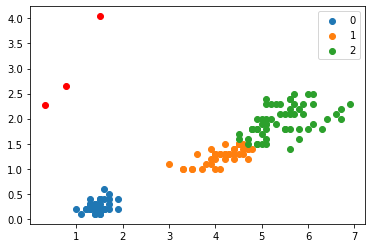

In [114]:
import matplotlib.pyplot as plt

u_labels = np.unique(target)

distances = cdist(data, results[0]  ,'euclidean')
points = np.array([np.argmin(i) for i in distances])

for i in u_labels:
    plt.scatter(results[0][i][0],results[0][i][1], c="r")
    plt.scatter(data[points == i , 0] , data[points == i , 1] , label = i)


plt.legend()
plt.show()

# K-means com PSO

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os

def Evaluate_State(state, data, target):
    distances = cdist(data, state ,'euclidean')
    points = np.array([np.argmin(i) for i in distances])

    return accuracy_score(target, points)

def Get_PSO(nr_Centroids, bounds, data, target, nr_Size=10, nr_Inertia=0.5, pa=0.8, ga=0.9,
            nr_Max_Velocity=10, nr_Iters=100, b_Verbose=False, nm_Function=None):

    bounds = np.array(bounds)
    assert np.all(bounds[:,0] < bounds[:,1])
    dim = len(bounds)
    X = []
    for j in range(nr_Size):
        X += [[[random.uniform(0, 5), random.uniform(0, 5)] for i in range(nr_Centroids)]]
    print('## Optimize:',nm_Function)

    def clip_by_norm(x, max_norm):
        norm = np.linalg.norm(x)
        return x if norm <=max_norm else x * max_norm / norm

    particles = X
    velocities = X
    personal_bests = np.copy(particles)
    personal_best_fitness = [0 for p in particles]

    global_best_idx = np.argmin(personal_best_fitness)
    global_best = personal_bests[global_best_idx]
    global_best_fitness = Evaluate_State(global_best, data,target)

    history = {'particles':[],
               'global_best_fitness':[],
               'global_best':[[np.inf, np.inf, np.inf] for i in range(nr_Iters)],
               'obj_func': nm_Function,}


    for i in range(nr_Iters):
        history['particles'].append(particles)
        history['global_best_fitness'].append(global_best_fitness)

        history['global_best'][i][0] = global_best[0]
        history['global_best'][i][1] = global_best[1]
        history['global_best'][i][2] = global_best[2]

        if b_Verbose: print('iter# {}:'.format(i), end='')

        for p_i in range(nr_Size):
            fitness = Evaluate_State(particles[p_i], data,target)
            if fitness > personal_best_fitness[p_i]:
                personal_bests[p_i] = particles[p_i]
                personal_best_fitness[p_i] = fitness

        if np.max(personal_best_fitness) > global_best_fitness:
            global_best_idx = np.argmax(personal_best_fitness)
            global_best = personal_bests[global_best_idx]
            global_best_fitness = Evaluate_State(global_best, data,target)

        m = nr_Inertia * np.array(velocities)
        acc_local = pa * np.random.rand() * (personal_bests - particles)
        acc_global = ga * np.random.rand() * (global_best - particles)

        velocities = m + acc_local + acc_global
        velocities = clip_by_norm(velocities, nr_Max_Velocity)

        particles = particles + velocities

        if b_Verbose:
            print(' Fitness:{:.5f}, Position:{}, Velocity:{}'.format(global_best_fitness, global_best, np.linalg.norm(velocities)))

    return history


history = Get_PSO(3, [[0,5],[0,5]],  data, target, nr_Size=100, nr_Inertia=0.5, nr_Iters=50, b_Verbose=1, nm_Function='k-means')

print('global best:',history['global_best_fitness'][-1], ', global best position:', history['global_best'][-1])

## Optimize: k-means
iter# 0: Fitness:0.88000, Position:[[2.56636943 0.3246943 ]
 [3.81299212 1.88899088]
 [4.4838629  3.12065698]], Velocity:10.0
iter# 1: Fitness:0.91333, Position:[[3.62643657 1.71494462]
 [3.99346134 1.63378488]
 [5.63271798 1.58687143]], Velocity:10.0
iter# 2: Fitness:0.91333, Position:[[3.62643657 1.71494462]
 [3.99346134 1.63378488]
 [5.63271798 1.58687143]], Velocity:10.0
iter# 3: Fitness:0.94000, Position:[[2.13207599 1.23923026]
 [3.88987636 1.44661983]
 [4.75914638 2.91560014]], Velocity:10.0
iter# 4: Fitness:0.97333, Position:[[1.89777289 1.8213657 ]
 [3.35400053 1.56865822]
 [4.91830848 3.05841631]], Velocity:10.000000000000002
iter# 5: Fitness:0.97333, Position:[[1.89777289 1.8213657 ]
 [3.35400053 1.56865822]
 [4.91830848 3.05841631]], Velocity:10.0
iter# 6: Fitness:0.97333, Position:[[1.89777289 1.8213657 ]
 [3.35400053 1.56865822]
 [4.91830848 3.05841631]], Velocity:10.000000000000002
iter# 7: Fitness:0.97333, Position:[[1.89777289 1.8213657 ]
 [3.35400

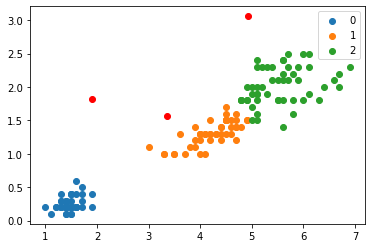

In [116]:
import matplotlib.pyplot as plt

u_labels = np.unique(target)

distances = cdist(data, history['global_best'][-1] ,'euclidean')
points = np.array([np.argmin(i) for i in distances])

for i in u_labels:
    plt.scatter(history['global_best'][-1][i][0],history['global_best'][-1][i][1], c="r")
    plt.scatter(data[points == i , 0] , data[points == i , 1] , label = i)

plt.legend()
plt.show()